In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(114514)

In [22]:
#奖励服从伯努利分布的老虎机
class Machine():
    def __init__(self,p):
        self.p=p
    def forward(self):
        return np.random.random()<self.p
    
class Game():
    def __init__(self,K):
        self.K=K
        self.machines=[]
        self.random_prods=np.random.uniform(size=K)
        for i in range(K):
            self.machines.append(Machine(self.random_prods[i]))
        self.best_prod=np.max(self.random_prods)
        self.best_id=np.argmax(self.random_prods)
    def step(self,k):
        return self.machines[k].forward()
    def get_p(self,k):
        return self.machines[k].p
np.random.seed(72)
game=Game(10)
print(game.best_id,game.best_prod)

6 0.7160737882919961


### 累计懊悔
#### 

In [23]:
class Agent():
    def __init__(self,game):
        self.game=game
        self.counts=np.zeros(self.game.K)
        self.regret=0
        self.actions=[]
        self.regrets=[]
        self.awards=0
    def update_regret(self,k):
        self.regret+=self.game.best_prod-self.game.get_p(k)
        self.regrets.append(self.regret)
    def run_one_step(self):
        pass
    def get_awards(self,k):
        return self.game.step(k)
    def run(self,steps):
        for i in range(steps):
            k=self.run_one_step()
            self.counts[k]+=1
            self.actions.append(k)
            self.awards+=self.get_awards(k)
            self.update_regret(k)

### ϵ-贪心算法
#### 每次以概率1-ϵ选择以往经验中期望奖励估值最大的那根拉杆（利用），以概率ϵ随机选择一根拉杆（探索

In [24]:
class epsGreedy(Agent):
    def __init__(self,game,eps=0.01,init_prod=1.0):
        super().__init__(game)
        self.eps=eps
        self.prods=np.array([init_prod]*self.game.K)
    def run_one_step(self):
        if np.random.random()<self.eps:
            k=np.random.randint(0,self.game.K)
        else:
            k=np.argmax(self.prods)
        r=self.get_awards(k)
        self.prods[k]=1.0/(self.counts[k]+1)*r+self.counts[k]/(self.counts[k]+1)*self.prods[k]
        return k

epsilon-贪婪算法的累积懊悔为： 14.285317198397411


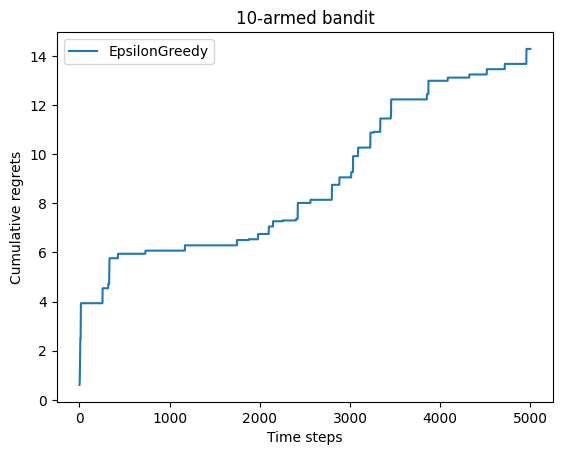

In [38]:
def plot_results(agents,agent_names):
    for i,agent in enumerate(agents):
        time_list=range(len(agent.regrets))
        plt.plot(time_list,agent.regrets,label=agent_names[i])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % agents[0].game.K)
    plt.legend()
    plt.show()
epsilon_greedy_agent = epsGreedy(game, eps=0.01)
epsilon_greedy_agent.run(5000)
print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_agent.regret)
plot_results([epsilon_greedy_agent], ["EpsilonGreedy"])
    
    

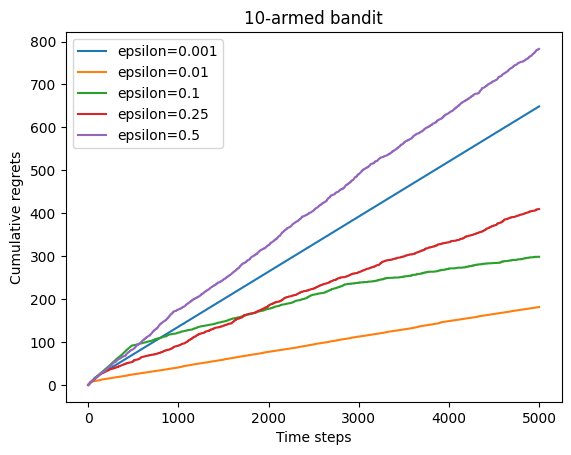

In [34]:
np.random.seed(555)
epsilons = [1e-3, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_agent_list = [
    epsGreedy(game, eps=e) for e in epsilons
]
epsilon_greedy_agent_names = ["epsilon={}".format(e) for e in epsilons]
for agent in epsilon_greedy_agent_list:
    agent.run(5000)

plot_results(epsilon_greedy_agent_list, epsilon_greedy_agent_names)

epsilon值衰减的贪婪算法的累积懊悔为： 4.696199744237335


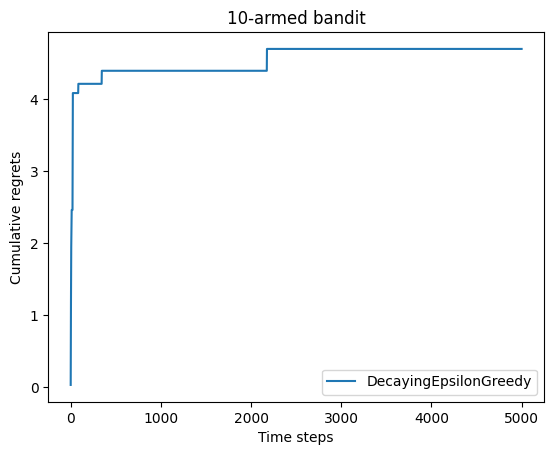

In [52]:
#eps=1/t
class Delay_epsGreedy(Agent):
    def __init__(self,game,init_p=1.0):
        super().__init__(game)
        self.game=game
        self.prods=np.array([init_p]*self.game.K)
        self.count_step=0
    def run_one_step(self):
        self.count_step+=1
        eps=1.0/self.count_step
        if np.random.random()<eps:
            k=np.random.randint(0,self.game.K)
        else:
            k=np.argmax(self.prods)
        r=self.get_awards(k)
        self.prods[k]+=1/(self.counts[k]+1)*(r-self.prods[k])
        return k
    
np.random.seed(55555)
agent2 = Delay_epsGreedy(game)
agent2.run(5000)
print('epsilon值衰减的贪婪算法的累积懊悔为：',agent2.regret)
plot_results([agent2], ["DecayingEpsilonGreedy"])
        

### 上置信界算法

81.19412026031837


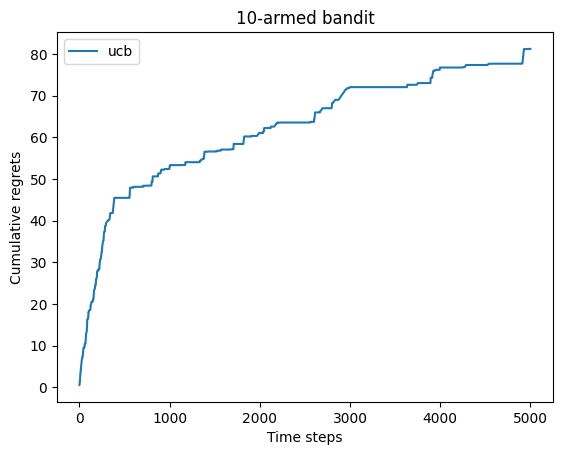

In [54]:
class UCB(Agent):
    def __init__(self,game,c,init_p=1.0):
        super().__init__(game)
        self.prods=np.array([init_p]*self.game.K)
        self.count_step=0
        self.c=c
    def run_one_step(self):
        self.count_step+=1
        ucb=self.prods+self.c*np.sqrt(np.log(self.count_step)/(2*(self.counts+1)))
        k=np.argmax(ucb)
        r=self.get_awards(k)
        self.prods[k]+=1/(self.counts[k]+1)*(r-self.prods[k])
        return k
np.random.seed(1)
coef=1.0#不确定性比重
ucb=UCB(game,coef)
ucb.run(5000)
print(ucb.regret)
plot_results([ucb],['ucb'])

## 汤普森采样

81.19412026031837


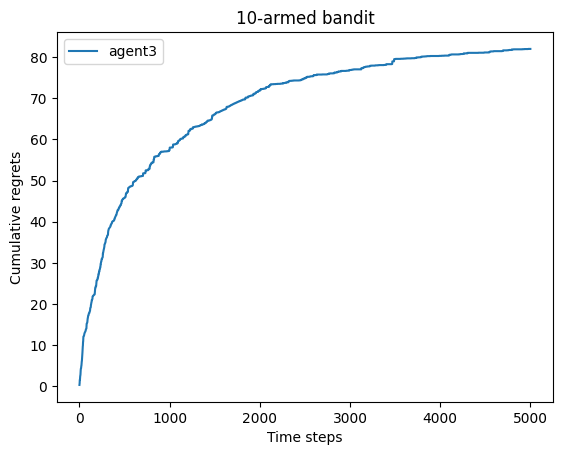

In [55]:
class ThompsonSampling(Agent):
    def __init__(self,game):
        super().__init__(game)
        self._a=np.ones(self.game.K)
        self._b=np.ones(self.game.K)
    def run_one_step(self):
        samples=np.random.beta(self._a,self._b)
        k=np.argmax(samples)
        r=self.get_awards(k)
        self._a[k]+=r
        self._b[k]+=1-r
        return k
agent3=ThompsonSampling(game)
agent3.run(5000)
print(ucb.regret)
plot_results([agent3],['agent3'])